In [1]:
!wget --no-check-certificate -O example.zip https://drive.google.com/uc?id=1VTGxBlf-wyO6CjAKWikaVnZZ-YPQpYJB
!unzip example.zip


--2024-01-01 21:01:12--  https://drive.google.com/uc?id=1VTGxBlf-wyO6CjAKWikaVnZZ-YPQpYJB
Resolving drive.google.com (drive.google.com)... 142.251.175.100, 142.251.175.102, 142.251.175.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.175.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p0lfqal86mnbb22r5js8sm8kat937bs1/1704142875000/16601359149676800360/*/1VTGxBlf-wyO6CjAKWikaVnZZ-YPQpYJB?uuid=d6a6366c-3a76-4bb0-823a-91eb0bddae7e [following]
--2024-01-01 21:01:15--  https://doc-14-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p0lfqal86mnbb22r5js8sm8kat937bs1/1704142875000/16601359149676800360/*/1VTGxBlf-wyO6CjAKWikaVnZZ-YPQpYJB?uuid=d6a6366c-3a76-4bb0-823a-91eb0bddae7e
Resolving doc-14-0s-docs.googleusercontent.com (doc-14-0s-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to do

In [2]:
# %pip uninstall tensorflow
# %pip install tensorflow
# %pip install keras
# %pip install gensim
# %pip install nltk
# %pip install torch
%pip install fasttext

import re
from collections import Counter
import pandas as pd
import numpy as np
# import tensorflow as tf
import nltk, re
# from keras.preprocessing.text import Tokenizer
from datetime import datetime
from gensim.models import *
import logging
import fasttext
# from rnn_utils import *
%matplotlib inline


''' D_NAMES: This is a list containing names of various Arabic diacritics. Each
 element of the list represents a specific diacritic type. '''
D_NAMES = ['Fathatan', 'Dammatan', 'Kasratan', 'Fatha', 'Damma', 'Kasra', 'Shadda', 'Sukun']

##############################################################################################

''' NAME2DIACRITIC: This uses a dictionary comprehension to create a mapping
from diacritic names to their corresponding Unicode characters.'''
NAME2DIACRITIC = dict((name, chr(code)) for name, code in zip(D_NAMES, range(0x064B, 0x0653)))

##############################################################################################

''' DIACRITIC2NAME: This is the inverse of the previous dictionary.'''
DIACRITIC2NAME = dict((code, name) for name, code in NAME2DIACRITIC.items())

##############################################################################################

''' ARABIC_DIACRITICS: This creates a frozenset containing the Unicode
 characters of all the diacritics.'''
ARABIC_DIACRITICS = frozenset(NAME2DIACRITIC.values())


# Remove all standard diacritics from the text, leaving the letters only.
def clear_diacritics(text):
    assert isinstance(text, str)
    return ''.join([l for l in text if l not in ARABIC_DIACRITICS])


# Return the diacritics from the text while keeping their original positions.
def extract_diacritics(text):
    assert isinstance(text, str)
    diacritics = []
    classes = []
    temp = ''
    for i in range(1, len(text)):
        temp = ''
        if text[i] in ARABIC_DIACRITICS:
            if text[i-1] == NAME2DIACRITIC['Shadda']:
                diacritics[-1] = (DIACRITIC2NAME[text[i-1]], DIACRITIC2NAME[text[i]])
                temp = (DIACRITIC2NAME[text[i-1]], DIACRITIC2NAME[text[i]])
                if (temp == ('Shadda', 'Fatha')):
                    classes.pop()
                    classes.append(8)
                elif (temp == ('Shadda', 'Fathatan')):
                    classes.pop()
                    classes.append(9)
                elif (temp == ('Shadda', 'Damma')):
                    classes.pop()
                    classes.append(10)
                elif (temp == ('Shadda', 'Dammatan')):
                    classes.pop()
                    classes.append(11)
                elif (temp == ('Shadda', 'Kasra')):
                    classes.pop()
                    classes.append(12)
                elif (temp == ('Shadda', 'Kasratan')):
                    classes.pop()
                    classes.append(13)
            else:
                diacritics.append(DIACRITIC2NAME[text[i]])
                temp = DIACRITIC2NAME[text[i]]
                if (temp == 'Fatha'):
                    classes.append(0)
                elif (temp == 'Fathatan'):
                    classes.append(1)
                elif (temp == 'Damma'):
                    classes.append(2)
                elif (temp == 'Dammatan'):
                    classes.append(3)
                elif (temp == 'Kasra'):
                    classes.append(4)
                elif (temp == 'Kasratan'):
                    classes.append(5)
                elif (temp == 'Sukun'):
                    classes.append(6)
                elif (temp == 'Shadda'):
                    classes.append(7)
        elif text[i - 1] not in ARABIC_DIACRITICS:
            diacritics.append('')
            classes.append(14)

    if text[-1] not in ARABIC_DIACRITICS:
        diacritics.append('')
        classes.append(14)
    return diacritics, classes


def extract_arabic_words2(text):
    arabic_pattern = re.compile('[\u0600-\u06FF]+')
    arabic_matches = arabic_pattern.findall(text)
    result = ' '.join(arabic_matches)
    processed_text = re.sub(r'[؛،\.؟]+', '', result)
    final_processed_text = re.sub(r'\s+', ' ', processed_text)
    return final_processed_text


input_file_path = "train.txt"  # Replace with your input file path

def get_vectors_labels(input_file_path):
    with open(input_file_path, "r", encoding="utf-8") as input_file:
        input_text = input_file.read()

    arabic_words = extract_arabic_words2(input_text)

    output_words = clear_diacritics(arabic_words)
    words = output_words.split()
    words2 = arabic_words.split()
    words_array = [list(word) for word in words]
    words_array2 = [list(word2) for word2 in words2]

    output_without_spaces = arabic_words.replace(" ", "")
    output_without_spaces2 = output_words.replace(" ", "")
    array_of_chars = list(output_without_spaces)
    _,classes_extraction = extract_diacritics (output_without_spaces)


    num_feature = 30
    min_word_count = 1
    num_thread = 5
    window_size = 10
    down_sampling = 0.001
    iteration = 20

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model_fastText = FastText(words_array,
                            vector_size=num_feature,
                            window=window_size,
                            min_count=min_word_count,
                            workers=num_thread)


    j=0
    chars =[]
    char_vectors =[]
    char_classes=[]
    for word in words_array:
        for char in word:
            chars.append(char)
            char_classes.append(classes_extraction[j])
            vector = model_fastText.wv[char]
            char_vectors.append(vector)
            j=j+1
    return chars, char_classes, char_vectors

# print (j)
# print(chars[1])
# print(char_classes[1])
# print(char_vectors[1])



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 764.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199777 sha256=63f9f5c66ff1516556ce7638c4af80651080f7988782934d6d9188a076b9f48e
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
train_chars , train_char_classes, train_char_vectors = get_vectors_labels(input_file_path)
cv_chars , cv_char_classes, cv_char_vectors = get_vectors_labels("val.txt")

print (len(train_chars))
print (len(train_char_classes))
print (len(train_char_vectors))
print (train_chars[1])
print (train_char_classes[1])
print (train_char_vectors[1])

print (len(cv_chars))
print (len(cv_char_classes))
print (len(cv_char_vectors))


8351478
8351478
8351478
و
6
[ 0.15983047  0.45807773  0.39134502  0.06237854  0.25864896 -0.4497411
 -0.10579058  0.13231084 -0.29463574 -0.40685922 -0.57261354 -0.2514992
 -0.01655538  0.18161273 -0.2533154   0.23622485  0.45504826 -0.31396192
 -0.13635027  0.11519387  0.00759403  0.30333874 -0.19819988  0.39450607
 -0.30448318 -0.33920914 -0.7183431  -0.2891009  -0.36085957 -0.1004525 ]
421099
421099
421099


In [ ]:
# old code

# !pip install tensorflow
# !pip install keras
# !pip install gensim
# import re
# from collections import Counter
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# import nltk, re
# from keras.preprocessing.text import Tokenizer
# from datetime import datetime
# from gensim.models import *
# import logging
# # from rnn_utils import *
# %matplotlib inline


# ''' D_NAMES: This is a list containing names of various Arabic diacritics. Each
#  element of the list represents a specific diacritic type. '''
# D_NAMES = ['Fathatan', 'Dammatan', 'Kasratan', 'Fatha', 'Damma', 'Kasra', 'Shadda', 'Sukun']

# ##############################################################################################

# ''' NAME2DIACRITIC: This uses a dictionary comprehension to create a mapping
# from diacritic names to their corresponding Unicode characters.'''
# NAME2DIACRITIC = dict((name, chr(code)) for name, code in zip(D_NAMES, range(0x064B, 0x0653)))

# ##############################################################################################

# ''' DIACRITIC2NAME: This is the inverse of the previous dictionary.'''
# DIACRITIC2NAME = dict((code, name) for name, code in NAME2DIACRITIC.items())

# ##############################################################################################

# ''' ARABIC_DIACRITICS: This creates a frozenset containing the Unicode
#  characters of all the diacritics.'''
# ARABIC_DIACRITICS = frozenset(NAME2DIACRITIC.values())


# # Remove all standard diacritics from the text, leaving the letters only.
# def clear_diacritics(text):
#     assert isinstance(text, str)
#     return ''.join([l for l in text if l not in ARABIC_DIACRITICS])


# # Return the diacritics from the text while keeping their original positions.
# def extract_diacritics(text):
#     assert isinstance(text, str)
#     diacritics = []
#     classes = []
#     temp = ''
#     for i in range(1, len(text)):
#         temp = ''
#         if text[i] in ARABIC_DIACRITICS:
#             if text[i-1] == NAME2DIACRITIC['Shadda']:
#                 diacritics[-1] = (DIACRITIC2NAME[text[i-1]], DIACRITIC2NAME[text[i]])
#                 temp = (DIACRITIC2NAME[text[i-1]], DIACRITIC2NAME[text[i]])
#                 if (temp == ('Shadda', 'Fatha')):
#                     classes.pop()
#                     classes.append(8)
#                 elif (temp == ('Shadda', 'Fathatan')):
#                     classes.pop()
#                     classes.append(9)
#                 elif (temp == ('Shadda', 'Damma')):
#                     classes.pop()
#                     classes.append(10)
#                 elif (temp == ('Shadda', 'Dammatan')):
#                     classes.pop()
#                     classes.append(11)
#                 elif (temp == ('Shadda', 'Kasra')):
#                     classes.pop()
#                     classes.append(12)
#                 elif (temp == ('Shadda', 'Kasratan')):
#                     classes.pop()
#                     classes.append(13)
#             else:
#                 diacritics.append(DIACRITIC2NAME[text[i]])
#                 temp = DIACRITIC2NAME[text[i]]
#                 if (temp == 'Fatha'):
#                     classes.append(0)
#                 elif (temp == 'Fathatan'):
#                     classes.append(1)
#                 elif (temp == 'Damma'):
#                     classes.append(2)
#                 elif (temp == 'Dammatan'):
#                     classes.append(3)
#                 elif (temp == 'Kasra'):
#                     classes.append(4)
#                 elif (temp == 'Kasratan'):
#                     classes.append(5)
#                 elif (temp == 'Sukun'):
#                     classes.append(6)
#                 elif (temp == 'Shadda'):
#                     classes.append(7)
#         elif text[i - 1] not in ARABIC_DIACRITICS:
#             diacritics.append('')
#             classes.append(14)

#     if text[-1] not in ARABIC_DIACRITICS:
#         diacritics.append('')
#         classes.append(14)
#     return diacritics, classes


# def extract_arabic_words2(text):
#     arabic_pattern = re.compile('[\u0600-\u06FF]+')
#     arabic_matches = arabic_pattern.findall(text)
#     result = ' '.join(arabic_matches)
#     processed_text = re.sub(r'[؛،\.]+', '', result)
#     final_processed_text = re.sub(r'\s+', ' ', processed_text)
#     return final_processed_text


# input_file_path = "train.txt"  # Replace with your input file path
# with open(input_file_path, "r", encoding="utf-8") as input_file:
#     input_text = input_file.read()

# arabic_words = extract_arabic_words2(input_text)

# output_words = clear_diacritics(arabic_words)
# words = output_words.split()
# words2 = arabic_words.split()
# words_array = [list(word) for word in words]
# words_array2 = [list(word2) for word2 in words2]

# output_without_spaces = arabic_words.replace(" ", "")
# output_without_spaces2 = output_words.replace(" ", "")
# array_of_chars = [char for char in output_without_spaces]
# _,classes_extraction = extract_diacritics (output_without_spaces)


# num_feature = 10
# min_word_count = 1
# num_thread = 5
# window_size = 10
# down_sampling = 0.001
# iteration = 20

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# model_fastText = FastText(words_array,
#                         vector_size=num_feature,
#                         window=window_size,
#                         min_count=min_word_count,
#                         workers=num_thread)


# j=0
# chars =[]
# char_vectors =[]
# char_classes=[]
# for word in words_array:
#   for char in word:
#     chars.append(char)
#     char_classes.append(classes_extraction[j])
#     vector = model_fastText.wv[char]
#     char_vectors.append(vector)
#     j=j+1

# print (j)
# print(chars[1])
# print(char_classes[1])
# print(char_vectors[1])


In [ ]:
# # prompt: save char_vectors and char_classes to disk to free some ram

# import pickle
# with open('char_vectors.pickle', 'wb') as handle:
#   pickle.dump(char_vectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('char_classes.pickle', 'wb') as handle:
#   pickle.dump(char_classes, handle, protocol=pickle.HIGHEST_PROTOCOL)


Exception ignored in: <function _xla_gc_callback at 0x7ffb3eca1120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
print(len(char_vectors))
print(len(char_classes))
print(char_vectors[:4])
print(char_classes[:4])


8353805
8353805
[array([-1.1812098 , -0.60070044, -0.7897395 , -0.5603433 ,  1.2305504 ,
       -0.25741428,  1.4790611 ,  1.2493821 ,  0.37425482,  0.92615455],
      dtype=float32), array([ 0.13610631,  0.5593434 , -0.1405848 ,  0.26972613, -0.57897645,
       -0.26760852, -0.11910333, -0.18808556,  0.08450229,  0.14508054],
      dtype=float32), array([ 0.87826335, -0.60334164,  0.44808203,  1.0347401 , -0.5278637 ,
       -0.16722888, -0.10494297, -0.30079252, -0.88877517,  0.59041756],
      dtype=float32), array([ 0.01499041,  0.26116854, -0.66562414, -0.68907225, -0.6339151 ,
       -0.5744119 ,  0.07547407, -0.7158053 ,  0.20950483, -0.5022661 ],
      dtype=float32)]
[0, 6, 2, 2]


In [ ]:
# prompt: generate pytorch class "TashkelaSet" that inherits from Dataset that takes char_vector as input X and char_classes as labels + define a function prepare_data that takes the path for the train.txt and val.txt and returns dataloaders


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk, re
from keras.preprocessing.text import Tokenizer
from datetime import datetime
from gensim.models import *
import logging

class TashkelaSet(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

def prepare_data(train_X, train_y):

  train_set = TashkelaSet(train_X, train_y)

  train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

  return train_loader



**Model**

In [ ]:

import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0):
        # Forward pass through the RNN
        out, hn = self.rnn(x, h0)

        # Select the output from the last time step
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)

        return out, hn

#####################
def train_model(model, train_loader):
    """
    Function for training the model
    """
    # define the optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # define the loss function
    criterion = nn.CrossEntropyLoss()
    # epochs
    epochs = 10
    # loop over the epochs
    for epoch in range(epochs):
        # initialize the hidden state
        h0 = torch.zeros(1, 3, model.hidden_size)
        # loop over the dataset
        for inputs, labels in train_loader:
            # zero the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat, h0 = model(inputs, h0)
            # calculate loss
            loss = criterion(yhat, labels)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        # print the loss
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
#####################

def evaluate_model(model, test_loader):
    """
    Function for evaluating the model
    """
    # initialize the hidden state
    h0 = torch.zeros(1, 3, model.hidden_size)
    # initialize the accuracy
    correct = 0
    total = 0
    # deactivating autograd
    with torch.no_grad():
        # loop over the test dataset
        for inputs, labels in test_loader:
            # compute the model output
            yhat, h0 = model(inputs, h0)
            # get predictions from the maximum value
            _, predicted = torch.max(yhat.data, 1)
            # update total
            total += labels.size(0)
            # update correct
            correct += (predicted == labels).sum().item()
    # compute the accuracy
    accuracy = 100 * correct / total
    # print the accuracy
    print(f'Accuracy: {accuracy:.2f}')





In [ ]:
# # prompt: the above model consumes ram , rewrite it fixing this issue , and test it on 'train.txt' and 'val.txt'   with reasonable batch number


# import re
# from collections import Counter
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# import nltk, re
# from keras.preprocessing.text import Tokenizer
# from datetime import datetime
# from gensim.models import *
# import logging
# from diacritic names to their corresponding Unicode characters.'''
# import torch
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# import torch.nn as nn
# print(len(char_vectors))
# print(len(char_classes))
# print(char_vectors[:4])
# print(char_classes[:4])




# class TashkelaSet(Dataset):
#   def __init__(self, X, y):
#     self.X = X
#     self.y = y

#   def __len__(self):
#     return len(self.X)

#   def __getitem__(self, idx):
#     return self.X[idx], self.y[idx]

# def prepare_data(train_X, train_y):

#   train_set = TashkelaSet(train_X, train_y)

#   train_loader = DataLoader(train_set, batch_size=4*256*10, shuffle=True)

#   return train_loader


# # **Model**


# class SimpleRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1):
#         super(SimpleRNN, self).__init__()

#         # RNN layer
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

#         # Fully connected layer
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x, h0):
#         # Forward pass through the RNN
#         out, hn = self.rnn(x, h0)

#         # Select the output from the last time step
#         out = out[:, -1, :]

#         # Fully connected layer
#         out = self.fc(out)

#         return out, hn

# #####################
# def train_model(model, train_loader):
#     """
#     Function for training the model
#     """
#     # define the optimization
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#     # define the loss function
#     criterion = nn.CrossEntropyLoss()
#     # epochs
#     epochs = 10
#     # loop over the epochs
#     for epoch in range(epochs):
#         # initialize the hidden state
#         h0 = torch.zeros(1, 3, hidden_size)
#         # loop over the dataset
#         for inputs, labels in train_loader:
#             # zero the gradients
#             optimizer.zero_grad()
#             # compute the model output
#             yhat, h0 = model(inputs, h0)
#             # calculate loss
#             loss = criterion(yhat, labels)
#             # credit assignment
#             loss.backward()
#             # update model weights
#             optimizer.step()
#         # print the loss
#         print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
# #####################

# def evaluate_model(model, test_loader):
#     """
#     Function for evaluating the model
#     """
#     # initialize the hidden state
#     h0 = torch.zeros(1, 3, hidden_size)
#     # initialize the accuracy
#     correct = 0
#     total = 0
#     # deactivating autograd
#     with torch.no_grad():
#         # loop over the test dataset
#         for inputs, labels in test_loader:
#             # compute the model output
#             yhat, h0 = model(inputs, h0)
#             # get predictions from the maximum value
#             _, predicted = torch.max(yhat.data, 1)
#             # update total
#             total += labels.size(0)
#             # update correct
#             correct += (predicted == labels).sum().item()
#     # compute the accuracy
#     accuracy = 100 * correct / total
#     # print the accuracy
#     print(f'Accuracy: {accuracy:.2f}')




# train_loader = prepare_data(train_X, train_y)
# test_loader = prepare_data(test_X, test_y)
# model = SimpleRNN(input_size=3, hidden_size=128, output_size=4)
# train_model(model, train_loader)
# evaluate_model(model, test_loader)


In [ ]:
# prompt: now test the whole code in action , train , validate/evaluate and feel free to add necessary code , that name of the train file is train.txt  and validation set is val.txt

# **Data Preparation**

train_path = 'train.txt'
val_path = 'val.txt'

train_loader = prepare_data(char_vectors, char_classes)

# **Model Definition**

input_size = len(char_vectors)
hidden_size = 128
output_size = len(char_classes)

model = SimpleRNN(input_size, hidden_size, output_size)

# **Training**

# train_model(model, train_loader)

# **Evaluation**

# evaluate_model(model, val_loader)


# new tests


In [46]:
# prompt: generate pytorch class "TashkelaSet" that inherits from Dataset that takes char_vector as input X and char_classes as labels + define a function prepare_data that takes the path for the train.txt and val.txt and returns dataloaders


# import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# import pandas as pd
# import numpy as np
# # import tensorflow as tf
# import nltk, re
# from keras.preprocessing.text import Tokenizer
# from datetime import datetime
# from gensim.models import *
# import logging

class TashkelaSet(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

def prepare_data(train_X, train_y, cv_X, cv_y):

  train_set = TashkelaSet(train_X, train_y)
  cv_set = TashkelaSet(cv_X, cv_y)

  train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
  cv_loader = DataLoader(cv_set, batch_size=32, shuffle=True)
  return train_loader, cv_loader







In [47]:
train_loader, cv_loader = prepare_data(train_char_vectors, train_char_classes, cv_char_vectors, cv_char_classes)


In [80]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)#,bidirectional=True)
        # self.batch_norm = nn.BatchNorm1d(2 * hidden_size)  # Add Batch Normalization
        self.fc = nn.Linear(hidden_size, num_classes)
        #softmax layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Set initial hidden and cell states
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        h0 = torch.zeros(self.num_layers , x.size(0), self.hidden_size).to(device)  # Adjust the num_layers
        c0 = torch.zeros(self.num_layers , x.size(0), self.hidden_size).to(device)  # Adjust the num_layers
        #adjust the shape of the input to be (batch_size, seq_length, input_size)
        x = x.view(x.size(0), -1, x.size(1))


        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out = self.batch_norm(out[:, -1, :])

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out
# def train_model(model, train_loader, cv_loader, criterion, optimizer, num_epochs=4):
#     train_losses = []
#     cv_losses = []
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         train_losses.append(running_loss / len(train_loader))
#         model.eval()
#         with torch.no_grad():
#             running_loss = 0.0
#             for inputs, labels in cv_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 running_loss += loss.item()
#             cv_losses.append(running_loss / len(cv_loader))
#         print('Epoch [{}/{}], Train Loss: {:.4f}, CV Loss: {:.4f}'.format(epoch+1, num_epochs, train_losses[-1], cv_losses[-1]))
#         scheduler.step()
#     # Save the model state dictionary
#     torch.save(model.state_dict(), 'LSTM_model_state.pth')
#     return train_losses, cv_losses
def train_model(model, train_loader, cv_loader, criterion, optimizer, num_epochs=4):
    train_losses = []
    cv_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Train Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            running_loss = 0.0

            for batch_idx, (inputs, labels) in enumerate(cv_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                if batch_idx % 50 == 0:
                    print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(cv_loader)}], Loss: {loss.item():.4f}')

            cv_losses.append(running_loss / len(cv_loader))

        print('Epoch [{}/{}], Train Loss: {:.4f}, CV Loss: {:.4f}'.format(epoch + 1, num_epochs, train_losses[-1], cv_losses[-1]))
        # scheduler.step()

    # Save the model state dictionary
    torch.save(model.state_dict(), 'LSTM_model_state.pth')

    return train_losses, cv_losses



'''to load:
# Create an instance of the model
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load('best_model.pth'))

'''

def evaluate_model(model, loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    return 100 * correct / total







Streaming output truncated to the last 5000 lines.
Train Epoch [3/4], Batch [75000/260984], Loss: 2.3284
Train Epoch [3/4], Batch [75100/260984], Loss: 2.2012
Train Epoch [3/4], Batch [75200/260984], Loss: 2.1651
Train Epoch [3/4], Batch [75300/260984], Loss: 2.1048
Train Epoch [3/4], Batch [75400/260984], Loss: 2.3217
Train Epoch [3/4], Batch [75500/260984], Loss: 2.1981
Train Epoch [3/4], Batch [75600/260984], Loss: 2.3505
Train Epoch [3/4], Batch [75700/260984], Loss: 2.3158
Train Epoch [3/4], Batch [75800/260984], Loss: 2.2398
Train Epoch [3/4], Batch [75900/260984], Loss: 2.3009
Train Epoch [3/4], Batch [76000/260984], Loss: 2.2875
Train Epoch [3/4], Batch [76100/260984], Loss: 2.3979
Train Epoch [3/4], Batch [76200/260984], Loss: 2.2618
Train Epoch [3/4], Batch [76300/260984], Loss: 2.1949
Train Epoch [3/4], Batch [76400/260984], Loss: 2.2344
Train Epoch [3/4], Batch [76500/260984], Loss: 2.2794
Train Epoch [3/4], Batch [76600/260984], Loss: 2.4009
Train Epoch [3/4], Batch [76700

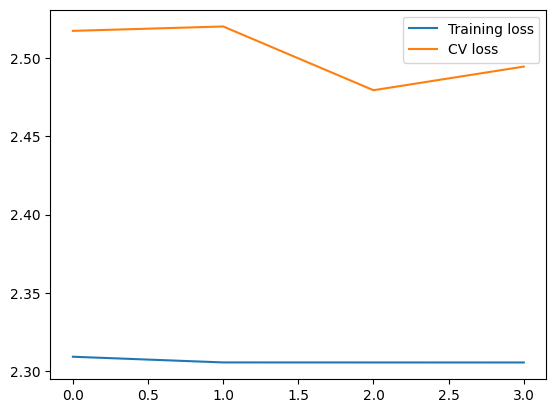

Train Accuracy: 50.98540496826172%
CV Accuracy: 30.805818557739258%


In [81]:
from torch.optim.lr_scheduler import StepLR

# Add this before the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input_size = 30
hidden_size = 128
num_layers = 2
num_classes = 15
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
train_losses, cv_losses = train_model(model, train_loader, cv_loader, criterion, optimizer,num_epochs=4)

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(cv_losses, label='CV loss')
plt.legend()
plt.show()

print(f'Train Accuracy: {evaluate_model(model, train_loader)}%')
print(f'CV Accuracy: {evaluate_model(model, cv_loader)}%')



In [82]:
# prompt: save model to pickle file
import pickle
with open('my_model.pkl', 'wb') as f:
  pickle.dump(model, f)


In [83]:
# prompt: load pickle file

with open('my_model.pkl', 'rb') as f:
  model = pickle.load(f)


Test set


In [85]:
def get_vectors_labels_test(input_file_path):
    with open(input_file_path, "r", encoding="utf-8") as input_file:
        input_text = input_file.read()

    arabic_words = extract_arabic_words2(input_text)

    words2 = arabic_words.split()
    words_array2 = [list(word2) for word2 in words2]

    output_without_spaces = arabic_words.replace(" ", "")
    array_of_chars = list(output_without_spaces)



    num_feature = 30
    min_word_count = 1
    num_thread = 5
    window_size = 10
    down_sampling = 0.001
    iteration = 20

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model_fastText = FastText(words_array2,
                            vector_size=num_feature,
                            window=window_size,
                            min_count=min_word_count,
                            workers=num_thread)


    j=0
    chars =[]
    chars_ids =[]
    char_vectors =[]
    for word in words_array2:
        for char in word:
            chars.append(char)
            chars_ids.append(j)
            vector = model_fastText.wv[char]
            char_vectors.append(vector)
            j=j+1
    return chars, char_vectors

#testing on test set
test_chars , test_char_vectors = get_vectors_labels_test("test_no_diacritics.txt")
print(len(test_chars))
print(len(test_char_vectors))
print(test_chars[:4])
print(test_char_vectors[:4])


417359
417359
['ل', 'ي', 'س', 'ل']
[array([-0.06572159,  0.37408006, -0.00900088,  0.201948  , -0.6701244 ,
       -0.15967184,  0.49180537, -0.17840898, -0.225788  , -0.11249827,
        0.1526382 ,  0.25382394, -0.467847  ,  0.11619159,  0.02250389,
       -0.07813775, -0.09147421, -0.05372789, -0.46988225,  0.18384594,
        0.53914964,  0.00878673,  0.1135644 , -0.15464863,  0.72732115,
       -0.1918299 ,  0.05576751,  0.26127416,  0.14233221, -0.5202197 ],
      dtype=float32), array([ 0.0606834 , -0.29521686,  0.8848596 ,  0.04648639,  0.05363831,
       -0.11667493, -0.8786195 ,  0.02480554, -0.2538165 ,  0.27396232,
        0.29898322,  0.09297802, -0.07608764, -0.2286924 , -0.28239256,
       -0.14778797,  0.07466491,  0.2739046 , -0.5420493 , -0.01865689,
        0.22764352, -0.27037624, -0.17710064,  0.1410111 ,  0.23976085,
        0.42523053, -0.00422423,  0.02255716, -0.18304661,  0.08887133],
      dtype=float32), array([-0.4350845 , -0.23389651,  0.00677163, -0.27542

In [91]:

#loading the model
import pickle
import io

# class CPU_Unpickler(pickle.Unpickler):
#     def find_class(self, module, name):
#         if module == 'torch.storage' and name == '_load_from_bytes':
#             return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
#         else:
#             return super().find_class(module, name)
# model = CPU_Unpickler(open('my_model.pkl', 'rb')).load()

# prompt: load pickle file

with open('my_model.pkl', 'rb') as f:
  model = pickle.load(f)


#predicting on test set
def predict_test(model,test_char_vectors):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_char_vectors = torch.tensor(test_char_vectors).to(device)
        test_char_vectors = test_char_vectors
        outputs = model(test_char_vectors)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.tolist()
        # for i in range(len(test_chars)):
        #     test_chars[i] = test_chars[i] + NAME2DIACRITIC[DIACRITIC2NAME[predicted[i]]]
        # test_chars = ''.join(test_chars)
        return predicted
predicted_chars = predict_test(model,test_char_vectors)
print(len(predicted_chars))

#saving the output to a file csv that has 2 columns (id, prediction)
import csv
j=0
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "label"])
    for i in range(len(test_chars)):
        writer.writerow([i, predicted_chars[i]])
        j=j+1


print(j)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


417359
417359
